Today I am going to do a little exploratory analysis of the <a href="https://github.com/thegetty/provenance-index-csv/tree/master/knoedler">Getty Research Institute's Knoedler Stock Books dataset</a>, which contains over 40,000 sales records from the stockbooks of art dealer M. Knoedler & Co dating from 1872–1970. I'm not familiar with the dataset, so I'm going to start by answering a simple question that will give us a sense of the scope of the data: Based on when Knoedler acquired and sold artworks, when was Knoedler most active?

First, let's do our standard imports:

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Next, let's load our dataset and get a sense for its size:

In [6]:
knoedler = pd.read_csv('../data/knoedler.csv')

knoedler.shape

/Users/zrottman/miniconda3/envs/test/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (5,6,7,36,42,43,44,47,50,51,52,54,55,56,68,71,72,73,75,76,77,80,88) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


So, we are dealing here with a sizeable dataset consisting, as advertised, of 40,250 salesbook records, each with 89 columns or variables. Based on this warning message, it looks like we'll have to clean up the dataset a little and make sure that our datatypes are accurate. We'll get to that later.

Before we start to answer our question about Knoedler's period of activity, let's figure out what a few sample rows of data look like:

In [4]:
knoedler_sample = knoedler.sample(3)

pd.options.display.max_rows = 90 # We want all 89 variables here, unabbreviated 

knoedler_sample.T

,37251,6534,14222
pi_record_no,K-37323,K-6536,K-14227
stock_book_no,11,4,6
knoedler_number,A8708,4392,14647
page_number,172,24,190
row_number,36,33,3
consign_no,NaN,NaN,NaN
consign_name,NaN,NaN,NaN
consign_loc,NaN,NaN,NaN
artist_name_1,"Daumier, Honore",Schenck,J. Israels
art_authority_1,"DAUMIER, HONORÉ VICTORIN","SCHENCK, AUGUST FRIEDRICH ALBRECHT","ISRAËLS, JOZEF"


Now we have a rough picture of the kind of information a given entry may have (or may not have). As we can see, we should be prepared for quite a bit of missing information. This doesn't surprise me, since we're dealing with messy, real-world data transcribed from hand-written stockbooks maintained by multiple individuals over the course of nearly a century: some information may be elided or obscured, whereas other variables will not be applicable in every case (for example, seconds artists or second buyers).

Let's return to the task at hand: When was Knoedler was most active? In particular, we are interested in sorting out when artworks entered Knoedler's stockbooks (for now, the year will suffice: entry_date_year) and when they exited (sale_date_year). Because there's evidently much data missing, it would be helpful to get a sense for how representative the data from these two fields are of the entire dataset:

In [5]:
entry_count = knoedler.entry_date_year.notnull().sum() # Count the non-null entries for entry_date_year
sale_count = knoedler.sale_date_year.notnull().sum() # Count the non-null entries for sale_date_year
total_count = len(knoedler) # Count the number of entries in the full dataset

print("entry_date_year size: {0} entries ({1:.2f}% of database entries)".
      format(entry_count, entry_count/total_count*100))
print("sale_date_year size: {0} entries ({1:.2f}% of database entries)".
      format(sale_count, sale_count/total_count*100))

entry_date_year size: 38264 entries (95.07% of database entries)
sale_date_year size: 27569 entries (68.49% of database entries)


As we can see above, ~95% of the entries in the original dataset have a non-null entry_date_year associated with them, whereas only ~68% of the original dataset has a sale_date_year. Does the lower number of sale dates point to the fact that a significant proportion of artworks remained unsold? Perhaps--this is a hypothesis to explore later. For now, this observation simply helps contextualize the graphical representations of the dealer's activity that we're about to perform.

Now it's time to draw up a histogram to visualize the dealer's periods of activity. What I'd like is a stacked histogram that shows us total transactional activity (the sum of its acquisitions and its sales) while also clearly differentiating these two variables. Seaborn's histogram function provides a convenient way of doing this, but it will require consolidating and simplifying our data so that we can represent the year of the transaction along the x-axis and the transaction type (i.e., acquisition or sale) by color. We're aiming for a DataFrame, in other words, with two columns--transaction_year and transaction_type--indexed by the unique identifier pi_record_no.

I'll start by creating a new DataFrame with only the non-null entry_date_year values:

In [9]:
entry_date_year = knoedler.dropna(subset=['entry_date_year'])[['pi_record_no', 'entry_date_year']]
entry_date_year

,pi_record_no,entry_date_year
0,K-1,1906.0
1,K-2,1876.0
2,K-3,1876.0
3,K-4,1876.0
4,K-5,1876.0
...,...,...
40245,K-40442,1875.0
40246,K-23858,1875.0
40247,K-23859,1875.0
40248,K-40336,1902.0


Next, let's rename add a new column specifying transaction type and then renamning the existing entry_date_year column to refer to the generic transaction year:

In [19]:
entry_date_year['transaction_type'] = 'entry'
entry_date_year.rename(columns={'entry_date_year':'transaction_year'}, inplace=True)
entry_date_year

,pi_record_no,transaction_year,transaction_type
0,K-1,1906,entry
1,K-2,1876,entry
2,K-3,1876,entry
3,K-4,1876,entry
4,K-5,1876,entry
...,...,...,...
40245,K-40442,1875,entry
40246,K-23858,1875,entry
40247,K-23859,1875,entry
40248,K-40336,1902,entry


Now let's do the same thing for our sales data:

In [18]:
sale_date_year = knoedler.dropna(subset=['sale_date_year'])[['pi_record_no', 'sale_date_year']]
sale_date_year.rename(columns={'sale_date_year':'transaction_year'}, inplace=True)
sale_date_year['transaction_type'] = 'sale'
sale_date_year

,pi_record_no,transaction_year,transaction_type
0,K-1,1907.0,sale
1,K-2,1878.0,sale
2,K-3,1878.0,sale
3,K-4,1877.0,sale
4,K-5,1877.0,sale
...,...,...,...
40245,K-40442,1875.0,sale
40246,K-23858,1875.0,sale
40247,K-23859,1875.0,sale
40248,K-40336,1905.0,sale


Time to concatenate! Incidentally, now that we've expunged all those pesky NaN values, we can also recast the transaction year data to integers, so I'll do that, too:

In [21]:
activity = pd.concat([entry_date_year, sale_date_year], ignore_index=True)
activity['transaction_year'] = activity['transaction_year'].astype(int)
activity

,pi_record_no,transaction_year,transaction_type
0,K-1,1906,entry
1,K-2,1876,entry
2,K-3,1876,entry
3,K-4,1876,entry
4,K-5,1876,entry
...,...,...,...
65828,K-40442,1875,sale
65829,K-23858,1875,sale
65830,K-23859,1875,sale
65831,K-40336,1905,sale


Just to see what we've got, let's reindex this new DataFrame hierarchically according to the unique record id and then the transaction type:

In [23]:
activity.set_index(['pi_record_no', 'transaction_type']).sort_index().head(20)

transaction_year
pi_record_no transaction_type                  
K-1          entry                         1906
             sale                          1907
K-10         entry                         1876
             sale                          1879
K-100        entry                         1876
             sale                          1879
K-1000       entry                         1878
K-10000      entry                         1889
             sale                          1889
K-10001      entry                         1889
             sale                          1889
K-10002      entry                         1889
K-10003      entry                         1889
             sale                          1890
K-10004      entry                         1889
K-10005      entry                         1889
             sale                          1890
K-10006      entry                         1889
K-10007      entry                         1889
             sale                          1890

This new multi-indexed DataFrame allows us to easily see that some objects were acquired and then resold, while others only have an entry date (perhaps they were not resold) or only a sale date (missing data?). Note that because the unique id number is a string, the data is sorted alphabetically and not as we expect.

In any event, with our new DataFrame we're ready to take advantage of seaborn's histogram function, since we can simply plot the transaction year data along the x-axis and color-code according to the transaction type category:

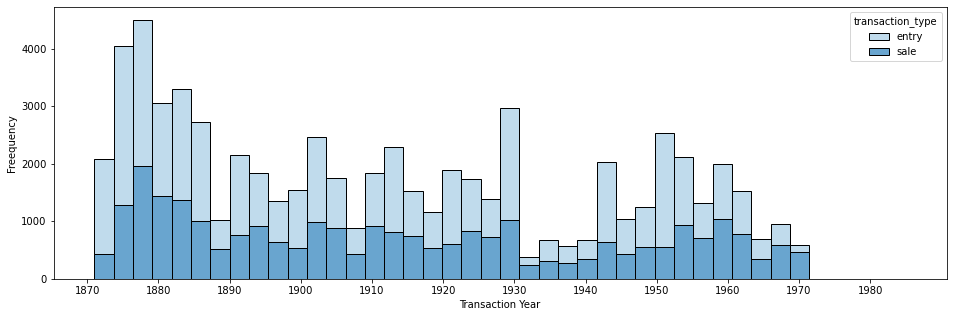

In [60]:
plt.figure(figsize=(16, 5))

sns.histplot(
    activity, 
    x='transaction_year', 
    multiple='stack', 
    hue='transaction_type', 
    palette='Blues',
)

plt.xticks(range(1870, 1990, 10))
plt.xlabel("Transaction Year")
plt.ylabel("Freequency");

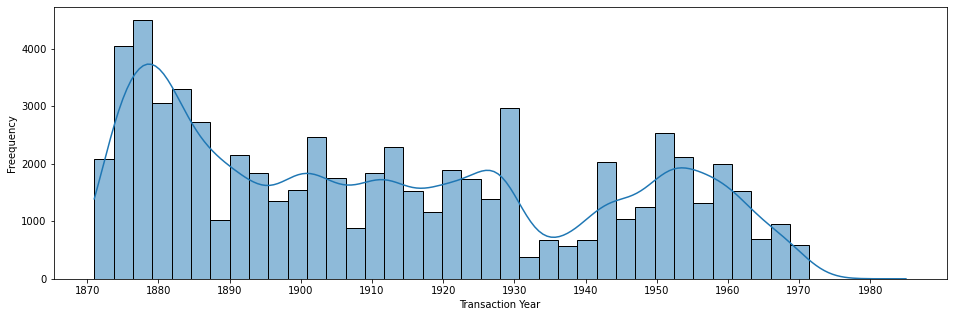

In [63]:
plt.figure(figsize=(16, 5))

sns.histplot(
    activity, 
    x='transaction_year', 
    palette='Blues',
    kde=True
)

plt.xticks(range(1870, 1990, 10))
plt.xlabel("Transaction Year")
plt.ylabel("Freequency");

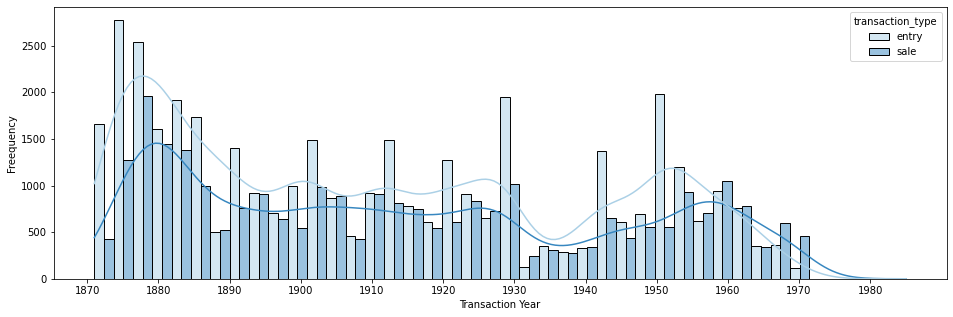

In [64]:
plt.figure(figsize=(16, 5))

sns.histplot(
    activity, 
    x='transaction_year', 
    multiple='dodge',
    hue='transaction_type', 
    palette='Blues',
    kde=True
)

plt.xticks(range(1870, 1990, 10))
plt.xlabel("Transaction Year")
plt.ylabel("Freequency");

There we have it! In this stacked histogram, we can clearly see Knoedler's total transactional activity (acquisitions + sales) over time. Apparently the dealer was most active around 1880.